In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_ENABLE_X64"] = "True"

import lagrangebench
import haiku as hk
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib.animation as animation

2024-01-25 13:31:03.484220: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/uppili11/.local/lib/python3.10/site-packages/jax/_src/api_util.py:229: SyntaxWarning: Jitted function has invalid argnames {'case_integrate_temp'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [2]:
ht2d_train = lagrangebench.data.HT2D("train", extra_seq_length=5)  # extra_seq_length=5 will be clear later
ht2d_valid = lagrangebench.data.HT2D("valid", extra_seq_length=20)

print(
    f"This is a {ht2d_train.metadata['dim']}D dataset "
    f"called {ht2d_train.metadata['case']}.\n"
    f"Train snapshot have shape {ht2d_train[0][2].shape} (n_nodes, seq_len).\n"
    f"Val snapshot have shape {ht2d_valid[0][2].shape} (n_nodes, rollout).\n"
)

This is a 2D dataset called HT.
Train snapshot have shape (950, 12) (n_nodes, seq_len).
Val snapshot have shape (950, 26) (n_nodes, rollout).



In [3]:
def gns(x):
    return lagrangebench.GNS(
        particle_dimension=ht2d_train.metadata["dim"],
        latent_size=16,
        blocks_per_step=2,
        num_mp_steps=4,
        particle_type_embedding_size=8,
    )(x)

gns = hk.without_apply_rng(hk.transform_with_state(gns))

noise_std = 3e-4

pf_config = lagrangebench.PushforwardConfig(
    steps=[-1, 500, 700],  # training steps to unlock the relative stage
    unrolls=[0, 2, 5],  # number of unroll steps per stage
    probs=[7, 2, 1],  # relative probabilities to unroll to the relative stage
)

bounds = np.array(ht2d_train.metadata["bounds"])
box = bounds[:, 1] - bounds[:, 0]

ht2d_case = lagrangebench.case_builder(
    box=box,  # (x,y) array with the world size along each axis. (1.0, 1.0) for 2D TGV
    metadata=ht2d_train.metadata,  # metadata dictionary
    input_seq_length=6,  # number of consecutive time steps fed to the model
    isotropic_norm=False,  # whether to normalize each dimension independently
    noise_std=noise_std,  # noise standard deviation used by the random-walk noise
)

In [4]:
trainer = lagrangebench.Trainer(
    model=gns,
    case=ht2d_case,
    data_train=ht2d_train,
    data_valid=ht2d_valid,
    pushforward=pf_config,
    noise_std=noise_std,
    metrics=["mse"],
    n_rollout_steps=20,
    eval_n_trajs=1,
    lr_start=5e-4,
    log_steps=10,
    eval_steps=50,
    batch_size_infer=1,
)

params, state, _ = trainer(step_max=100)

/home/uppili11/.local/lib/python3.10/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(


['acc', 'temp_diff']
(950,)
(950, 2)


AssertionError: 

In [5]:
ht2d_test = lagrangebench.HT2D("test", extra_seq_length=20)

In [6]:
metrics = lagrangebench.infer(
    gns,
    ht2d_case,
    ht2d_test,
    params,
    state,
    metrics=["mse", "sinkhorn"],
    eval_n_trajs=1,
    n_rollout_steps=20,
    rollout_dir="rollouts/",
    out_type="pkl",
    batch_size=1,
)["rollout_0"]
rollout = pickle.load(open("rollouts/rollout_0.pkl", "rb"))

hello
1
950
hello
hello


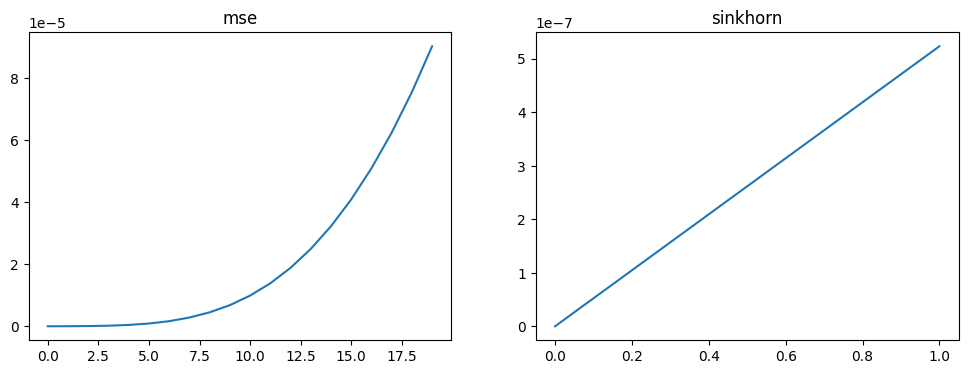

In [7]:
# plot metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# plot the metrics
for i, m in enumerate(["mse", "sinkhorn"]):
    ax[i].plot(metrics[m])
    ax[i].set_title(m)

In [9]:
print(f"rollout of shape {rollout['predicted_rollout'].shape} (steps, nodes, xy pos)")

fig, ax = plt.subplots(1, 2)
ax[0].set_xlim([0, 1.0])
ax[0].set_ylim([0, 1.0])
ax[1].set_xlim([0, 1.0])
ax[1].set_ylim([0, 1.0])
fig.set_size_inches(10, 5, forward=True)
ax[0].set_title("GNS")
ax[1].set_title("Ground Truth")

rollout_len = rollout["predicted_rollout"].shape[0] - 1

scat0 = ax[0].scatter(
    rollout["predicted_rollout"][0, :, 0], rollout["predicted_rollout"][0, :, 1]
)
scat1 = ax[1].scatter(
    rollout["ground_truth_rollout"][0, :, 0], rollout["ground_truth_rollout"][0, :, 1]
)


def animate(i):
    scat0.set_offsets(rollout["predicted_rollout"][i])
    scat1.set_offsets(rollout["ground_truth_rollout"][i])
    return scat0, scat1


ani = animation.FuncAnimation(
    fig, animate, repeat=True, frames=rollout_len, interval=50
)

plt.close(fig)

writer = animation.PillowWriter(fps=10, metadata=dict(artist="Me"), bitrate=1800)
ani.save("media/scatter2.gif", writer=writer)

from IPython.display import Image

Image(url="media/scatter2.gif")

rollout of shape (26, 950, 2) (steps, nodes, xy pos)
